# Import Prequisites

In [0]:
# prerequisites
from torch.autograd import Variable    
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
#import torchbearer
import torchvision
from torchvision.transforms import ToTensor
from skimage import color, data, restoration
from scipy.signal import convolve2d
from PIL import Image
import glob
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import random 
import torch.utils.data as data
from astropy.convolution import Gaussian2DKernel
import cv2
from torch.utils.data import ConcatDataset
from torchvision.utils import save_image
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset, DataLoader


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Get Data

In [0]:
import os
 
'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles  

## Transformed images are saved before hand, and read from google drive folders to hasten learning process

In [0]:

dirName = '/content/drive/My Drive/p_0.8/transformed_block_inverse_0.8'
# Get the list of all files in directory tree at given path
listOfFiles = getListOfFiles(dirName)

In [0]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


listOfFiles.sort(key=natural_keys)
#print(listOfFiles)

In [0]:
len(listOfFiles)

38904

## To ensure we''re reading the the right label for each image based on their index

In [0]:
indexes = []
def get_im_indexes(lis):
  for element in lis:
    
    pref = '/content/drive/My Drive/p_0.8/transformed_block_inverse_0.8/transformed_block_p=0.8_index='
    suff = '.pt'
    x = element[len(pref):]
    x = x[:-len(suff)]
    indexes.append(int(x))
  return indexes 

In [0]:
get_im_indexes(listOfFiles)

In [0]:
import numpy as np
data = np.load('/content/drive/My Drive/targets.npy',allow_pickle=True)
#print(data.item())
print(len(data.item()))

38904


In [0]:
list_of_labels_array_form = list(data[()].values())

In [0]:
 
Labels = torch.stack([torch.tensor(classlabel) for c,classlabel in enumerate(list_of_labels_array_form) if c in indexes])

print(len(Labels))
print(type(Labels))

38904
<class 'torch.Tensor'>


# Construct Generator
## Generator has 2 Convolutional layers, and 2 Linear layers as per specification by the authors of the Ambient GAN paper

In [0]:
class ModelG(nn.Module):
    def __init__(self):
        self.z_dim = 100
        super(ModelG, self).__init__()
        self.fc2 = nn.Linear(10, 1000)
        self.fc = nn.Linear(self.z_dim+1000, 64*28*28)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 5, 1, 2)
    #weight_init
    
    def weight_init(self, mean, std):
      for m in self._modules:
        normal_init(self._modules[m], mean, std)
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        y_ = self.fc2(labels)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)
        x = self.fc(x)
        x = x.view(batch_size, 64, 28, 28)
        x = self.bn1(x) 
        x = F.relu(x)
        x = self.deconv1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = torch.tanh(x)
        return x

# Construct Discriminator

In [0]:
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1  = nn.Linear(64*28*28+1000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.fc3 = nn.Linear(10, 1000)
    # weight_init
    
    def weight_init(self, mean, std):
      for m in self._modules:
        normal_init(self._modules[m], mean, std)
           
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, 28,28)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(batch_size, 64*28*28)
        y_ = self.fc3(labels)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Provision to Initialize weights in D and G

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [0]:
INPUT_SIZE = 784
SAMPLE_SIZE = 1000
NUM_LABELS = 10

In [0]:
model_d = ModelD()
model_g = ModelG()
criterion = nn.BCELoss()
input = torch.FloatTensor(128, INPUT_SIZE)
noise = torch.FloatTensor(128, (100))
    


In [0]:
fixed_noise = torch.FloatTensor(SAMPLE_SIZE, 100).normal_(0,1)
fixed_labels = torch.zeros(SAMPLE_SIZE, NUM_LABELS)


for i in range(NUM_LABELS):
  for j in range(SAMPLE_SIZE // NUM_LABELS):
    fixed_labels[i*(SAMPLE_SIZE // NUM_LABELS) + j, i] = 1.0
    
label = torch.FloatTensor(128)
one_hot_labels = torch.FloatTensor(128, 10)

In [0]:
model_d.weight_init(mean=0.0, std=0.05)
model_d.cuda()
model_g.weight_init(mean=0.0, std=0.05)
model_g.cuda()

ModelG(
  (fc2): Linear(in_features=10, out_features=1000, bias=True)
  (fc): Linear(in_features=1100, out_features=50176, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [0]:

input, label = input.cuda(), label.cuda()
noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
fixed_labels = fixed_labels.cuda()

optim_d = optim.SGD(model_d.parameters(), lr=0.01)
optim_g = optim.SGD(model_g.parameters(), lr=0.01)
fixed_noise = Variable(fixed_noise.cuda())
fixed_labels = Variable(fixed_labels.cuda())

real_label = 1
fake_label = 0

# Create custom dataset
## create a dataset out of the images read from drive before feeding it to model

In [0]:
class MyDataset(Dataset):
    def __init__(self, file_paths, Labels, transform=None):
        self.file_paths = file_paths
        self.Labels = Labels
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             #transforms.Resize(img_size),
                                              transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.5],std=[0.5])])
        
    def __getitem__(self, index):
        x = torch.load(self.file_paths[index])
        y = self.Labels[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.file_paths)

In [0]:
customdataset = MyDataset(listOfFiles, Labels)
trainloader = DataLoader(
    customdataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

In [0]:
len(customdataset)

38904

# Train GAN

In [0]:
d_per_epoch_loss = []
g_per_epoch_loss = []


for epoch_idx in range(25):
  
  epoch_start_time = time.time()
  
  model_d.train()
  model_g.train()
  # learning rate decay
  if (epoch_idx+1) == 15:
        optim_d.param_groups[0]['lr'] /= 10
        optim_g.param_groups[0]['lr'] /= 10
        print("learning rate change!")

  if (epoch_idx+1) == 20:
        optim_d.param_groups[0]['lr'] /= 10
        optim_g.param_groups[0]['lr'] /= 10
        print("learning rate change!")

  d_loss = []
  g_loss = []
  
  for batch_idx, (train_x, train_y) in enumerate(trainloader):

    batch_size = train_x.size(0)

    train_x = train_x.view(-1, INPUT_SIZE)
   
    train_x = train_x.cuda()
    train_y = train_y.cuda()

    input.resize_as_(train_x).copy_(train_x)
    label.resize_(batch_size).fill_(real_label)
    one_hot_labels.resize_(batch_size, NUM_LABELS).zero_()
    one_hot_labels = one_hot_labels.cuda()
    one_hot_labels.scatter_(1, train_y.view(batch_size,1), 1)
    inputv = Variable(input)
    labelv = Variable(label)
    
    # ## Train D with all-real batch
    output = model_d(inputv, Variable(one_hot_labels)) # Forward pass real batch through D
    optim_d.zero_grad() # Calculate gradients for D in backward pass
    errD_real = criterion(output, labelv) #nn.BCELoss() # Calculate loss on all-real batch
    errD_real.backward()# Calculate gradients for D in backward pass
    realD_mean = output.data.cpu().mean()
    
    # ## Train D with fake batch
    one_hot_labels.zero_()
    rand_y = torch.from_numpy(
    np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
    one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
    noise.resize_(batch_size, 100).normal_(0,1)
    label.resize_(batch_size).fill_(fake_label)
    noisev = Variable(noise)
    labelv = Variable(label)
    onehotv = Variable(one_hot_labels)
    g_out = model_g(noisev, onehotv)
    output = model_d(g_out, onehotv)
    errD_fake = criterion(output, labelv)
    fakeD_mean = output.data.cpu().mean()
    
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    errD_fake.backward()
    optim_d.step() # optimize

    # train the G
    noise.normal_(0,1)
    one_hot_labels.zero_()
    rand_y = torch.from_numpy(
    np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
    one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
    label.resize_(batch_size).fill_(real_label)
    onehotv = Variable(one_hot_labels)
    noisev = Variable(noise)
    labelv = Variable(label)
    g_out = model_g(noisev, onehotv)
    output = model_d(g_out, onehotv)
    errG = criterion(output, labelv)
    optim_g.zero_grad()
    errG.backward()
    optim_g.step()
  
  
    d_loss.append(errD)
    g_loss.append(errG)
    
  epoch_end_time = time.time()  
  
  #g_out = model_g(fixed_noise, fixed_labels).data.view(SAMPLE_SIZE, 1, 28,28).cpu()
  #save_image(g_out, '{}/{}.png'.format('/content/drive/My Drive/p_0.99/res_no_norm', epoch_idx))
 
  
  d_per_epoch_loss.append(torch.mean(torch.stack(d_loss),dim=0)) 
  g_per_epoch_loss.append(torch.mean(torch.stack(g_loss),dim=0))
  
  #data_to_is = for_is_calc(g_out)
  #IS_DATA = DataLoader(data_to_is, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
  
  #if epoch_idx==24:
  #  IScore.append(inception_score(data_to_is,cuda=True,resize=True,splits=10))
  
  
  print('Epoch {} - D loss = {:.4f}, G loss = {:.4f}, Time taken in sec = {:.4f}'.format(epoch_idx, d_per_epoch_loss[epoch_idx], g_per_epoch_loss[epoch_idx],epoch_end_time-epoch_start_time))
  #print(IScore)
  


# Calculate Inception Score

In [0]:
import numpy as np
import datetime
import os, sys
try: 
    import torchbearer
except:
    !pip install torchbearer
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from skimage import color, data, restoration
from scipy.signal import convolve2d
from PIL import Image
import glob
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

     |████████████████████████████████| 92kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/6c/cb/69/466aef9cee879fb8f645bd602e34d45e754fb3dee2cb1a877a
Successfully built torchbearer


## We use the Better CNN model we created during labs, that gave >99% accuracy on prediction for MNIST dataset

In [0]:
import torch 
import torch.nn.functional as F
from torch import nn

# Model Definition
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out,0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out 

In [0]:
from torchvision.models.inception import inception_v3
from torch.autograd import Variable
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)
    print(N)
    print(type(imgs))

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    inception_model = BetterCNN()
    inception_model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/bettercnn.weights'))
    inception_model.eval();

   # up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 10))

    #for i, batch in enumerate(dataloader,0):
        #batchv = Variable(batch[0])
        #print(batchv.size())
        #preds[i*batch_size:i*batch_size + batch_size] = get_pred(batchv)
    print(imgs.size())
    preds = get_pred(imgs)
    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

       
    return np.mean(split_scores), np.std(split_scores)

## Send 1000 images to Inception score module

In [0]:
g_out = model_g(fixed_noise, fixed_labels).data.view(1000, 1, 28,28).cpu()

In [0]:
type(g_out)

torch.Tensor

In [0]:
scores = []

## Record score for images of different amounts of measurement(p=0,0.1,0.5,0.8,0.9,0.95,0.99)

In [0]:
scores.append(inception_score(g_out, cuda=True, batch_size=32, resize=False, splits=1)) 

1000
<class 'torch.Tensor'>
torch.Size([1000, 1, 28, 28])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
print(scores) 

In [0]:
baseline_scores = [9.78,8.43,7.00, 6.84,3.63,2.87,1.73]
ambient_gan_scores = [9.96,9.93,9.85,9.5,8.2,7.01,5.58] # collected from other gan
vanilla_gan_scores = [9.94,6.93,3.13,1.50,1.21,1.19,1.05] # collected from other gan
p_values = [0,0.1,0.5,0.8,0.9,0.95,0.99]


In [0]:
!pwd

/content


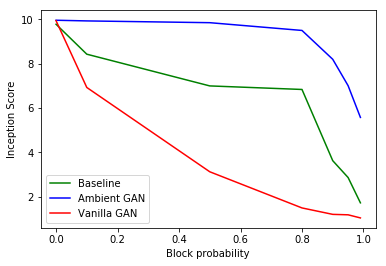

In [0]:

plt.plot(p_values,baseline_scores,c = 'g',label = 'Baseline')

plt.plot(p_values,ambient_gan_scores,c = 'b',label = 'Ambient GAN')

plt.plot(p_values,vanilla_gan_scores,c = 'r',label = 'Vanilla GAN')

plt.xlabel('Block probability')
plt.ylabel('Inception Score')
plt.legend()
plt.savefig('final.png')